## Ok, here I am. AI Rookie with his first Kaggle notebook.

I am working through the second chapter of fast.ai course and follow the hint of Jeremy Howard to work on a project with drives me.

### Drivetrain Approach

Jeremy Howard and fellows described the [Drivetrain Approach](https://www.oreilly.com/radar/drivetrain-approach-data-products/) as a four step process to build great data products.

#### First things first

1. Define objective

What outcome do I want to achive? In other words, what is the main goal of my project?

Using this solution, Users should be warned about malignant melanoms as early as possible. This could relieve suffering and save their lives. Even in developed countries like Germany it is not easy for everyone to organise a schedule by a dermatologist. It should be easy to use this solution for everyone by taking a photo of their skin mole and analyse it privately.   

2. Identify the Levers of the project which we can control

What input data to the project can we control to influence the outcome of the project?

We can control which dataset for the training of the model we want to use. The whole project must be able to run on an actual Android smartphone, without lacking any personal information to any service.

3. Which new data can we collect?

We can use an users image of his skin mole and try to classificate it according to the general dataset AND his own personal trained dataset collected over the time.

4. What model should we build?

How do the levers influence the outcome?

5. (Added from me) How can we optimize the model?

#### Questions to be solved

1. How can I find out that the project I want to work on is not too difficult for me?

Jeremy's hint:
***When selecting a project, the most important consideration is data availability.***

There exist a large dataset for melanom classification which I think I can use:

[SIIM-ISIC melanom classification competition](https://www.kaggle.com/competitions/siim-isic-melanoma-classification/overview)

So let me try to get access and interpret the ***ISIC 2020 Challenge Dataset***.

1.1 How can I link the dataset to my notebook? I don't want to copy all of the data everytime I try something new.

I made a video about it at my youtube channel [Kaggle demo](https://www.youtube.com/watch?v=_6gU3mqOjOs)

1.2 How can I programatically access this dataset?

Let us try out some things.

First let us import the fastbook module to get access to the Image class.

In [1]:
#hide
! pip install -Uqq fastbook


Than import it.

In [4]:
from fastbook import *


And define the path to the images for the training data in jpeg format.
The linked dataset is available through the input directory.

In [ ]:
training_path = '../input/siim-isic-melanoma-classification/jpeg/train/'
source = training_path + 'ISIC_0015719.jpg'
im = Image.open(source)
im.to_thumb(256,256)

     

Now that we have explored the dataset and can access it, we need to organise it in way that fastai can work with it.
As of now we only know that we have to put the different images classes into distict directories so that fastai can work with them.

Let us have a look at the train.csv file.

We can see, that for every image we have an entry benign or malignant. All we have to do right now is to create one directory for each of the benign or malignant melanoma and store the coresspondig image in it.

We will use the pandas library to read the train.csv file.

In [5]:
import pandas as pd

dataset_path = '../input/siim-isic-melanoma-classification/'
metadata = dataset_path + 'train.csv'

df = pd.read_csv(metadata)


We have 33126 images of melanoma in total.

In [6]:
benign = (df[['benign_malignant']] == 'benign').sum()
malignant =(df[['benign_malignant']] == 'malignant').sum()
target =(df[['target']] == 1).sum()

print('benign: {:d}, malignant: {:d}, target: {}'.format(benign[0], malignant[0], target[0]))


benign: 32542, malignant: 584, target: 584


From these 33126 images, 32542 images show benign melanoma and 584 show malignant melanoma.

Now let us build a list of all filenames which are malignant melanoma.



In [7]:
malignant_images = df.loc[df['benign_malignant'] == 'malignant']
malignant_images = malignant_images['image_name'].tolist()
numbers_of_malignant_images = len(malignant_images)

benign_images = df.loc[df['benign_malignant'] == 'benign']
benign_images = benign_images['image_name'].tolist()
numbers_of_benign_images = len(benign_images)

print('benign images: {:d}'.format(numbers_of_benign_images))
print('malignant images: {:d}'.format(numbers_of_malignant_images))

benign images: 32542
malignant images: 584


Let us implement a function wich stores a number of a specific type of melanoma images in a specific directory.

In [8]:
import os

def link_images(list_of_images, number, attribute, input_path, output_path):
    attribute_path = output_path + attribute

    if not os.path.exists(attribute_path):
            os.mkdir(attribute_path)
    
    for i in list_of_images:
        
        filename = i + '.jpg'
        src = input_path + filename
        dest = attribute_path + '/' + filename
        
#        print('linking ' + src + ' to ' + dest)
        if not os.path.exists(dest):
            os.symlink(src, dest)
            
        number = number - 1
        if number <= 0:
            break

    return
            

input_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
output_path = '/kaggle/working/training/'

if not os.path.exists(output_path):
    os.mkdir(output_path)

# let us prepare the malignant training images directory
link_images(malignant_images, 10, 'malignant', input_path, output_path)

# let us prepare the benign training images directory
link_images(benign_images, 10, 'benign', input_path, output_path)
   

In [ ]:
# source = output_path + 'malignant/' + 'ISIC_9998682.jpg'
# print(source)
# im = Image.open(source)
# im.to_thumb(256,256)

# Training Session

Using fastai means that we have to create a *DataLoaders* class.

*DataLoaders* is a thin python class which stores multiple DataLoader objects, normally a *train* and a associated *valid*

Transfer our linked SIIM-ISIC Melanoma Dataset to a DataLoaders object we need to tell fastai at least four things (TGLV):

## T.G.L.V (Type, Grab, Label, Validate) ##

1) Type - What kind of data are we working with?
2) Grab - How to get the list of items?
3) Label - How to label these items
4) Validate - How to create the validation set


Fastai provides a data block API. This API allows us to customize every stage which is needed to build a Dataloaders.
As a first try, we follow directly the instructions of the chapter 2 from fastai course.

First, we create naivly a Datablock with our melanoma training data.

In [10]:
melanoms = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

### Testing different image transforming methods.

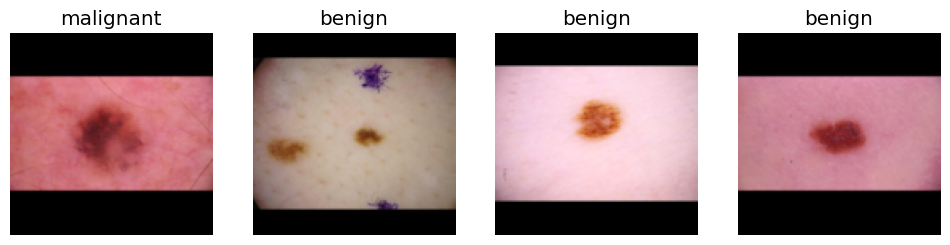

In [16]:
training_path = '/kaggle/working/training/'
melanoms_test = melanoms.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = melanoms.dataloaders(training_path)
dls.valid.show_batch(max_n=4, nrows=1)

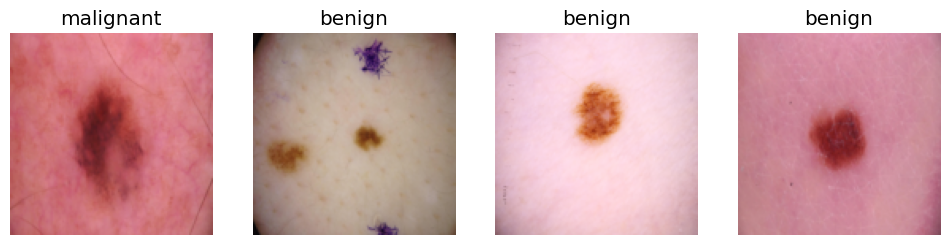

In [17]:
training_path = '/kaggle/working/training/'
melanoms_test = melanoms.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = melanoms.dataloaders(training_path)
dls.valid.show_batch(max_n=4, nrows=1)

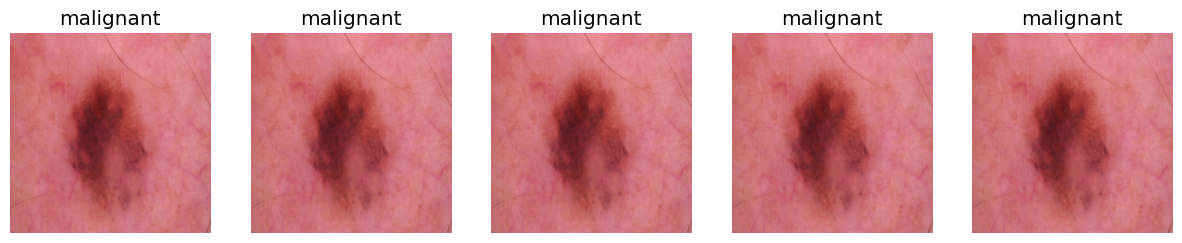

In [24]:
training_path = '/kaggle/working/training/'
melanoms_test = melanoms.new(item_tfms=RandomResizedCrop(256, min_scale=0.1))
dls = melanoms.dataloaders(training_path)
dls.valid.show_batch(max_n=5, nrows=1, unique=True)

In [8]:
training_path = '/kaggle/working/training/'
dls = melanoms.dataloaders(training_path)

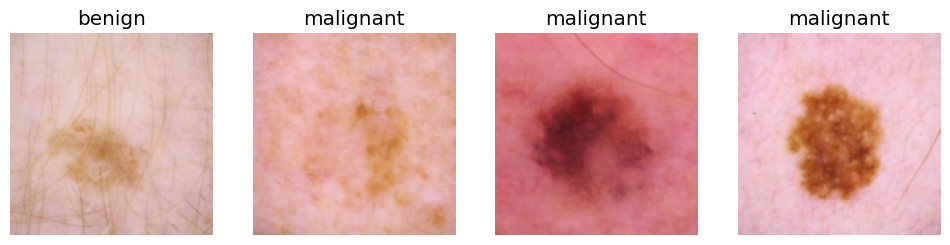

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)


But how do we have to organise the melanoma images to be able to train our modell with the specific labels?
Let us examine the parameters of the Datablock() function.